## Pump it Up: Data Mining the Water Table- Project#3

* Student name: ***Deepali Sharma***
* Student pace: ***Flex***
* Scheduled project review date/time: ***January, 2023***
* Instructor name: ***Abhineet Kulkarni***

### Data Exploration and Business Problem
* The data was obtained from the **Pump it Up: Data Mining the Water Table** provided at [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/). The data is collected from Taarifa and the Tanzanian Ministry of Water, and is used to predict which pumps are functional, which need some repairs, and which don't work at all! 


* The main focus of this project is to predict the status of water pumps. Based on our model we need to predict which water pumps are functioning, which ones need repairs, and which ones are not functioning at all. A complete list of variables in the dataset is given below

* `amount_tsh` - Total static head (amount water available to waterpoint)
* `date_recorded` - The date the row was entered
* `funder` - Who funded the well
* `gps_height` - Altitude of the well
* `installer` - Organization that installed the well
* `longitude` - GPS coordinate
latitude - GPS coordinate
wpt_name - Name of the waterpoint if there is one
num_private -
basin - Geographic water basin
subvillage - Geographic location
region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)
lga - Geographic location
ward - Geographic location
population - Population around the well
public_meeting - True/False
recorded_by - Group entering this row of data
scheme_management - Who operates the waterpoint
scheme_name - Who operates the waterpoint
permit - If the waterpoint is permitted
construction_year - Year the waterpoint was constructed
extraction_type - The kind of extraction the waterpoint uses
extraction_type_group - The kind of extraction the waterpoint uses
extraction_type_class - The kind of extraction the waterpoint uses
management - How the waterpoint is managed
management_group - How the waterpoint is managed
payment - What the water costs
payment_type - What the water costs
water_quality - The quality of the water
quality_group - The quality of the water
quantity - The quantity of water
quantity_group - The quantity of water
source - The source of the water
source_type - The source of the water
source_class - The source of the water
waterpoint_type - The kind of waterpoint
waterpoint_type_group - The kind of waterpoint


## Modeling

1. The data was split into training and test sets.
2. The data was pre-processed. This is a classification problem with three classes! A detailed data exploration was done to understand different variables provided in the dataset. See Notebook eda.ipynb in the same github repository
3. Several types of classifiers were built, tuned (using GridSearchCV to test combinations of hyperparameters) and validated:

    - Logistic Regression
    - Random Forest
    - XGradient Boosted
    - Stacking Classifier (using above models)


## Evaluation

4. I used Roc_Auc mostly and also looked at f-scores as the scoring metric for tuning hyperparameters and evaluating model performance. 

    * The Roc_Auc metric utilizes **"probabilities"** of class prediction. Based on that, we’re able to more precisely evaluate and compare the models. We also
    * We also care equally about positive and negative classes, and the roc curve gives a desirable balance between **sensitivity/recall (maximizing True positive Rate)** and and .
    * To bulid a good model one needs to carefully evaluate the predictions and understand the role of different features that drive the model predictions. A careful comparison between test and train data helps to understand to a great extent the model characteristics

In [1]:
import os, sys, time
print(sys.executable)

/usr/local/anaconda3/bin/python


In [80]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
#pd.set_option('display.max_rows', 10)
import seaborn as sns
#sns.set_style("whitegrid")
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mticker
import missingno as mssno

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix # if you are running an older version, use confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # You need imblearn Pipeline for Smote work in a Pipeline
from itertools import cycle
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 9.78 ms (started: 2023-01-04 19:41:00 -05:00)


In [3]:
from xgboost import XGBClassifier

time: 432 µs (started: 2023-01-03 15:10:17 -05:00)


In [116]:
# This function plots confusion matrix (train) as well as roc_auc, recall, and precision scores

def model_evaluation_roc_auc(model):
    with plt.style.context('seaborn-talk'):
        fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12, 5))

        # Plot confusion matrix for the test set
        ConfusionMatrixDisplay.from_estimator(baseline_logreg, X_test, y_test,normalize='true',ax=ax1,cmap='Blues')
        ConfusionMatrixDisplay.from_estimator(baseline_logreg, X_train, y_train,normalize='true',ax=ax2,cmap='Blues')
        ax1.grid(False) 
        ax2.set_title("Confusion Matrix - Train")
        
        # plot Roc curve for the test and train
        #plot_roc_curve(model,X_test,y_test,ax=axs[1,0])
        #plot_roc_curve(model,X_train,y_train,ax=axs[1,1])
        plt.show()
        
        # Print classification Scores for the test set
        y_true = y_test
        y_pred = model.predict(X_test)
        divider = ('----' * 14) 
        table_title = 'Classification Report - Test:'
        table = classification_report(y_true, y_pred, digits=3)
        print('\n', divider, table_title, divider, table, divider, divider, '\n' , sep='\n') 
        
        # Print roc_auc for test and train 
        #roc_score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                                        # cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()
        roc_score_train = roc_auc_score(y_train, model.predict_proba(X_train),multi_class='ovr') 
        roc_score_test = roc_auc_score(y_test, model.predict_proba(X_test),multi_class='ovr')
        
        y_train_pred   = model.predict(X_train)
        y_test_pred    = model.predict(X_test)
        # Find F- Scores:
        recall_score_train = recall_score(y_train, y_train_pred, average='weighted')
        recall_score_test = recall_score(y_test, y_test_pred, average='weighted')
        
        # Print accuracy for test and train 
        acc_score_train = accuracy_score(y_train, y_train_pred) 
        acc_score_test = accuracy_score(y_test,   y_test_pred)
        
        #print(f" Mean Cross Validated Roc_Auc Score: {roc_score_train_cv :.2%}")    
        print(f" Train Roc_Auc Score: {roc_score_train :.2%}")  
        print(f" Test Roc_Auc Score: {roc_score_test :.2%}")    
        print('\n', divider, '\n' , sep='\n')
        
        print(f" Train Accuracy Score: {acc_score_train :.2%}")  
        print(f" Test Accuracy Score: {acc_score_test :.2%}")    
        print('\n', divider, '\n' , sep='\n')
        
        print(f" Train Sensitivity/Recall score: {recall_score_train :.2%}")    
        print(f" Test Sensitivity/Recall score: {recall_score_test :.2%}")  
        print('\n', divider, '\n' , sep='\n')
        
        
        print('Train Weighted Precision: {:.2f}'.format(precision_score(y_train, y_train_pred, average='weighted')))
        print('Test Weighted Precision: {:.2f}'.format(precision_score(y_test, y_test_pred, average='weighted')))
        print("Train Score:{:.2f} ".format(model.score(X_train, y_train)))
        print("Test Score:{:.2f} ".format(model.score(X_test, y_test)))
                                       
        

time: 1.77 ms (started: 2023-01-04 19:59:21 -05:00)


In [58]:
def plot_roc_curve(model,X_test=X_test,y_test=y_test):
    y_onehot_test = label_binarizer.transform(y_test)
    y_score = model.predict_proba(X_test)
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")
    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
        )

    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()

time: 632 µs (started: 2023-01-04 18:24:07 -05:00)


time: 380 µs (started: 2023-01-04 19:26:19 -05:00)


In [6]:
def clean_installer(df):

    df['installer'] = df['installer'].astype(str).str.lower()
    df['installer'].replace(
        to_replace=(
            'fini water', 'fin water', 'finn water', 'finwater', 'finwate'),
        value='finw', inplace=True)
    df['installer'].replace(to_replace=('jaica co'), value='jaica', inplace=True)
    df['installer'].replace(
        to_replace=(
            'district water department', 'district water depar', 'district council',
            'district counci', 'village council orpha','kibaha town council',
            'village council', 'coun', 'village counil', 'council',
            'mbulu district council', 'counc', 'village council .oda',
            'sangea district coun', 'songea district coun', 'villege council',
            'district  council', 'quick win project /council', 'mbozi district council',
            'village  council', 'municipal council', 'tabora municipal council',
            'wb / district council'),
        value='council', inplace=True)
    df['installer'].replace(
        to_replace=(
            'rc church', 'rc churc', 'rcchurch/cefa', 'irc', 'rc', 'rc ch', 'hw/rc',
            'rc church/central gover', 'kkkt church', 'pentecost church', 'roman church',
            'rc/mission', 'rc church/cefa', 'lutheran church', 'tag church',
            'free pentecoste church of tanz', 'rc c', 'church', 'rc cathoric',
            'morovian church', 'cefa/rc church', 'rc mission', 'anglican church',
            'church of disciples', 'anglikana church', 'cetral government /rc',
            'pentecostal church', 'cg/rc', 'rc missionary', 'sda church', 'methodist church', 'trc',
            'rc msufi', 'haidomu lutheran church', 'baptist church', 'rc church brother',
            'st magreth church', 'anglica church', 'global resource co', 'rc mi',
            'baptist church of tanzania', 'fpct church', 'rc njoro', 'rc .church',
            'rc mis', 'batist church', 'churc', 'dwe/anglican church','missi', 'mission',
            'ndanda missions', 'rc/mission', 'cvs miss', 'missionaries', 'hydom luthelani',
            'luthe', 'haydom lutheran hospital', 'lutheran', 'missio', 'germany missionary',
            'grail mission kiseki bar', 'missionary', 'heri mission', 'german missionsry',
            'wamissionari wa kikatoriki', 'neemia mission', 'wamisionari wa kikatoriki'),
        value='church', inplace=True)
    df['installer'].replace(
        to_replace=(
            'central government', 'gove', 'central govt', 'gover', 'cipro/government',
            'governme', 'adra /government', 'isf/government', 'adra/government',
            'government /tcrs', 'village govt', 'government', 'government /community',
            'concern /government', 'goverm', 'village government', 'cental government',
            'govern', 'cebtral government', 'government /sda', 'tcrs /government',
            'tanzania government', 'centra govt', 'colonial government', 'misri government',
            'government and community', 'cetral government /rc', 'concern/government',
            'government of misri', 'lwi &central government', 'governmen', 'government/tcrs', 'government /world vision',
            'centra government'),
        value='tanzanian government', inplace=True)
    df['installer'].replace(
        to_replace=(
            'world vission', 'world division', 'word divisio','world visiin'),
        value='world vision', inplace=True)
    df['installer'].replace(to_replace=('unicrf'), value='unicef', inplace=True)
    df['installer'].replace(
        to_replace=(
            'commu', 'olgilai village community', 'adra /community', 'adra/community',
            'rwe/ community', 'killflora /community', 'communit', 'taboma/community',
            'arab community', 'adra/ community', 'sekei village community', 'rwe/community',
            'arabs community', 'village community', 'government /community',
            'dads/village community', 'killflora/ community', 'mtuwasa and community',
            'rwe /community', 'ilwilo community', 'summit for water/community',
            'igolola community', 'ngiresi village community', 'rwe community',
            'african realief committe of ku', 'twesa /community', 'shelisheli commission',
            'twesa/ community', 'marumbo community', 'government and community',
            'community bank', 'kitiangare village community', 'oldadai village community',
            'twesa/community', 'tlc/community', 'maseka community', 'islamic community',
            'district community j', 'village water commission', 'village community members',
            'tcrs/village community', 'village water committee', 'comunity'),
        value='community', inplace=True)
    df['installer'].replace(
        to_replace=(
            'danid', 'danda','danida co', 'danny', 'daniad', 'dannida', 'danids'),
        value='danida', inplace=True)
    df['installer'].replace(
        to_replace=(
            'hesaws', 'huches', 'hesaw', 'hesawz', 'hesawq', 'hesewa'),
        value='hesawa', inplace=True)
    df['installer'].replace(
        to_replace=(
            'dwsp', 'kkkt _ konde and dwe', 'rwe/dwe', 'rwedwe', 'dwe/', 'dw', 'dwr',
            'dwe}', 'dwt', 'dwe /tassaf', 'dwe/ubalozi wa marekani', 'consultant and dwe',
            'dwe & lwi', 'ubalozi wa marekani /dwe', 'dwe&', 'dwe/tassaf', 'dw$',
            'dw e', 'tcrs/dwe', 'dw#', 'dweb', 'tcrs /dwe', 'water aid/dwe', 'dww'),
        value='dwe', inplace=True)
    df['installer'].replace(
        to_replace=(
            'africa muslim', 'muslimu society(shia)', 'africa muslim agenc',
            'african muslims age', 'muslimehefen international','islamic',
            'the isla', 'islamic agency tanzania',  'islam', 'nyabibuye islamic center'),
        value='muslims', inplace=True)
    df['installer'].replace(
        to_replace=(
            'british colonial government', 'british government', 'britain'),
        value='british', inplace=True)
    df['installer'].replace(
        to_replace=(
            'tcrs/tlc', 'tcrs /care', 'cipro/care/tcrs', 'tcrs kibondo', 'tcrs.tlc',
            'tcrs /twesa', 'tassaf /tcrs', 'tcrs/care', 'tcrs twesa', 'rwe/tcrs',
            'tcrs/twesa', 'tassaf/ tcrs', 'tcrs/ tassaf', 'tcrs/ twesa', 'tcrs a',
            'tassaf/tcrs'),
        value='tcrs', inplace=True)
    df['installer'].replace(
        to_replace=(
            'kkkt-dioces ya pare', 'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme',
            'kkkt kilinga', 'kkkt canal', 'kkkt katiti juu', 'kkkt mareu'),
        value='kkkt', inplace=True)
    df['installer'].replace(to_replace=('norad/'), value='norad', inplace=True)
    df['installer'].replace( to_replace=('tasaf/dmdd', 'dmdd/solider'),
        value='dmdd', inplace=True)
    df['installer'].replace(
        to_replace=('cjejow construction', 'cjej0'), value='cjejow', inplace=True)
    df['installer'].replace(
        to_replace=(
            'china henan constuction', 'china henan contractor', 'china co.', 'chinese'),
        value='china', inplace=True)
    df['installer'].replace(
        to_replace=(
            'local contract', 'local technician', 'local', 'local  technician',
            'locall technician', 'local te', 'local technitian', 'local technical tec',
            'local fundi', 'local technical', 'localtechnician', 'village local contractor',
            'local l technician'),
        value='local', inplace=True)
    df['installer'].replace(
        to_replace=(
            'oikos e .africa', 'oikos e.africa', 'africa amini alama',
            'africa islamic agency tanzania', 'africare', 'african development foundation',
            'oikos e. africa', 'oikos e.afrika', 'afroz ismail', 'africa', 'farm-africa',
            'oikos e africa', 'farm africa', 'africaone', 'tina/africare', 'africaone ltd',
            'african reflections foundation', 'africa m'),
        value='africa', inplace=True)
    df['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
    df_installer_cnt = df.groupby('installer')['installer'].count()
    other_list = df_installer_cnt[df_installer_cnt<71].index.tolist()
    df['installer'].replace(to_replace=other_list, value='other', inplace=True)

time: 54.4 ms (started: 2023-01-03 17:08:48 -05:00)


In [7]:
def clean_funder(df):
    
    df['funder'] = df['funder'].astype(str).str.lower()
    df['funder'].replace(
        to_replace=(
            'kkkt_makwale', 'kkkt-dioces ya pare', 'world vision/ kkkt', 'kkkt church',
            'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme', 'kkkt canal', 'kkkt usa',
            'kkkt mareu'),
        value='kkkt', inplace=True)
    df['funder'].replace(
        to_replace=(
            'government of tanzania', 'norad /government', 'government/ community',
            'cipro/government', 'isf/government', 'finidagermantanzania govt',
            'government /tassaf', 'finida german tanzania govt', 'village government',
            'tcrs /government', 'village govt', 'government/ world bank',
            'danida /government', 'dhv/gove', 'concern /govern', 'vgovernment',
            'lwi & central government', 'government /sda', 'koica and tanzania government',
            'world bank/government', 'colonial government', 'misri government',
            'government and community', 'concern/governm', 'government of misri',
            'government/tassaf', 'government/school', 'government/tcrs', 'unhcr/government',
            'government /world vision', 'norad/government'),
        value='government', inplace=True)
    df['funder'].replace(
        to_replace=(
            'british colonial government', 'japan government', 'china government',
            'finland government', 'belgian government', 'italy government',
            'irish government', 'egypt government', 'iran gover', 'swedish', 'finland'),
        value='foreign government', inplace=True)
    df['funder'].replace(
        to_replace=(
            'rc church', 'anglican church', 'rc churc', 'rc ch', 'rcchurch/cefa',
            'irc', 'rc', 'churc', 'hw/rc', 'rc church/centr', 'pentecosta church',
            'roman church', 'rc/mission', "ju-sarang church' and bugango",
            'lutheran church', 'roman cathoric church', 'tag church ub', 'aic church',
            'free pentecoste church of tanz', 'tag church', 'fpct church', 'rc cathoric',
            'baptist church', 'morovian church', 'cefa/rcchurch', 'rc mission',
            'bukwang church saints', 'agt church', 'church of disciples', 'rc mofu',
            "gil cafe'church'", 'pentecostal church', 'bukwang church saint',
            'eung am methodist church', 'rc/dwe', 'cg/rc', 'eung-am methodist church',
            'rc missionary', 'sda church', 'methodist church', 'rc msufi',
            'haidomu lutheran church', 'nazareth church', 'st magreth church',
            'agape churc', 'rc missi', 'rc mi', 'rc njoro', 'world vision/rc church',
            'pag church', 'batist church', 'full gospel church', 'nazalet church',
            'dwe/anglican church', 'missi', 'mission', 'missionaries', 'cpps mission',
            'cvs miss', 'grail mission kiseki bar', 'shelisheli commission', 'missionary',
            'heri mission', 'german missionary', 'wamissionari wa kikatoriki',
            'rc missionary', 'germany missionary', 'missio', 'neemia mission', 'rc missi',
            'hydom luthelani', 'luthe', 'lutheran church',  'haydom lutheran hospital',
            'village council/ haydom luther', 'lutheran', 'haidomu lutheran church',
            'resolute golden pride project', 'resolute mininggolden pride',
            'germany cristians'),
        value='church', inplace=True)
    df['funder'].replace(
        to_replace=(
            'olgilai village community', 'commu', 'community', 'arab community',
            'sekei village community', 'arabs community', 'village community',
            'mtuwasa and community', 'ilwilo community', 'igolola community',
            'ngiresi village community', 'marumbo community', 'village communi',
            'comune di roma', 'comunity construction fund', 'community bank',
            "oak'zion' and bugango b' commu", 'kitiangare village community',
            'oldadai village community', 'tlc/community', 'maseka community',
            'islamic community',  'tcrs/village community', 'buluga subvillage community',
            'okutu village community'),
        value='community', inplace=True)
    df['funder'].replace(
        to_replace=(
            'council', 'wb / district council', 'cdtfdistrict council',
            'sangea district council', 'mheza distric counc', 'kyela council',
            'kibaha town council', 'swidish', 'mbozi district council', 
            'village council/ rose kawala',  'songea municipal counci',
            'quick win project /council', 'village council', 'villege council',
            'tabora municipal council', 'kilindi district co', 'kigoma municipal council',
            'district council', 'municipal council', 'district medical',
            'sengerema district council', 'town council', 'mkinga  distric cou',
            'songea district council', 'district rural project', 'mkinga distric coun',
            'dadis'),
        value='district', inplace=True)
    df['funder'].replace(
        to_replace=(
            'tcrs.tlc', 'tcrs /care', 'tcrst', 'cipro/care/tcrs', 'tcrs/care', 'tcrs kibondo'),
        value='tcrs', inplace=True)
    df['funder'].replace(
        to_replace=(
            'fini water', 'finw', 'fin water', 'finn water', 'finwater'),
        value='fini', inplace=True)
    df['funder'].replace(
        to_replace=(
            'islamic', 'the isla', 'islamic found', 'islamic agency tanzania',
            'islam', 'muislam', 'the islamic', 'nyabibuye islamic center', 'islamic society', 'african muslim agency',
            'muslims', 'answeer muslim grou', 'muslimu society(shia)',
            'unicef/african muslim agency', 'muslim world', 'muslimehefen international',
            'shear muslim', 'muslim society'),
        value='islam', inplace=True)
    df['funder'].replace(
        to_replace=('danida', 'ms-danish', 'unhcr/danida', 'tassaf/ danida'),
        value='danida', inplace=True)
    df['funder'].replace(
        to_replace=(
            'hesawa', 'hesawz', 'hesaw', 'hhesawa', 'hesawwa', 'hesawza', 'hesswa',
            'hesawa and concern world wide'),
        value='hesawa', inplace=True)
    df['funder'].replace(
        to_replace=('world vision/adra', 'game division', 'worldvision'),
        value='world vision', inplace=True)
    df['funder'].replace(
        to_replace=(
            'germany republi', 'a/co germany', 'aco/germany', 'bingo foundation germany',
            'africa project ev germany', 'tree ways german'),
        value='germany', inplace=True)
    df['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
    df_funder_cnt = df.groupby('funder')['funder'].count()
    other_list = df_funder_cnt[df_funder_cnt<98].index.tolist()
    df['funder'].replace(to_replace=other_list, value='other', inplace=True)    

time: 14.1 ms (started: 2023-01-03 17:09:16 -05:00)


In [4]:
df_data = pd.read_csv("Data_train.csv")
df_labels = pd.read_csv("Data_train_labels.csv")
df = pd.merge(df_data,df_labels,how='inner',left_on='id', right_on='id')
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


time: 1.1 s (started: 2023-01-03 15:10:17 -05:00)


In [26]:
df_clean= df

time: 11.9 ms (started: 2023-01-03 17:56:47 -05:00)


In [27]:
from datetime import date
from datetime import datetime
df_clean['date_recorded']=pd.to_datetime(df_clean['date_recorded'])
df_clean['yr_record']=df_clean['date_recorded'].dt.year.astype('int')
df_clean['month_record']=df_clean['date_recorded'].dt.month.astype('int')
df_clean[['date_recorded','yr_record','month_record']]
df_clean['age'] = (2014 - df_clean['construction_year'])
df_clean['age'] = df_clean['age'].replace(2014, 60)

time: 359 ms (started: 2023-01-03 17:56:49 -05:00)


In [28]:
conditions = [
    (df_clean['age'] <=5),
    (df_clean['age'] > 5) & (df_clean['age'] <= 10),
    (df_clean['age'] > 10) & (df_clean['age'] <= 15),
    (df_clean['age'] > 15) & (df_clean['age'] <= 20),
    (df_clean['age'] > 20) & (df_clean['age'] <= 25),
    (df_clean['age'] > 25) & (df_clean['age'] <= 30),
    (df_clean['age'] > 30) & (df_clean['age'] <= 35),
    (df_clean['age'] > 35) & (df_clean['age'] <= 40),
    (df_clean['age'] > 40) & (df_clean['age'] <= 45),
    (df_clean['age'] > 45) & (df_clean['age'] <= 50),
    (df_clean['age'] > 50) & (df_clean['age'] <= 55),
    (df_clean['age'] > 5) & (df_clean['age'] <= 60),
     ]
choices =[5,10,15,20,25,30,35,40,45,50,55,60]
df_clean['age'] = np.select(conditions,choices, default=0)

time: 71.3 ms (started: 2023-01-03 17:56:51 -05:00)


In [11]:
clean_installer(df_clean)

time: 3.18 s (started: 2023-01-03 17:24:01 -05:00)


In [31]:
cols_to_delete = ['id', 'recorded_by','funder', 'installer','yr_record',
                'lga', 'ward', 'region','scheme_management',
                 'wpt_name','scheme_name', 'extraction_type_class',
                 'extraction_type_group','management', 'payment_type', 
                 'quality_group', 'source_type', 'source', 
                 'waterpoint_type_group', 'quantity_group', 'basin',
                 'num_private','construction_year','date_recorded','month_record','recorded_by']

time: 15.8 ms (started: 2023-01-03 17:57:09 -05:00)


In [32]:
df_clean = df_clean.drop(cols_to_delete,axis=1)

time: 504 ms (started: 2023-01-03 17:57:10 -05:00)


In [18]:
df_clean=df_clean.drop('yr_record',axis=1)

time: 193 ms (started: 2023-01-03 17:27:16 -05:00)


In [33]:
df_clean

,amount_tsh,gps_height,longitude,latitude,basin,subvillage,region_code,district_code,population,public_meeting,permit,extraction_type,management_group,payment,water_quality,quantity,source_class,waterpoint_type,status_group,age
0,6000.0,1390,34.938093,-9.856322,Lake Nyasa,Mnyusi B,11,5,109,True,False,gravity,user-group,pay annually,soft,enough,groundwater,communal standpipe,functional,15
1,0.0,1399,34.698766,-2.147466,Lake Victoria,Nyamara,20,2,280,NaN,True,gravity,user-group,never pay,soft,insufficient,surface,communal standpipe,functional,5
2,25.0,686,37.460664,-3.821329,Pangani,Majengo,21,4,250,True,True,gravity,user-group,pay per bucket,soft,enough,surface,communal standpipe multiple,functional,5
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,90,63,58,True,True,submersible,user-group,never pay,soft,dry,groundwater,communal standpipe multiple,non functional,30
4,0.0,0,31.130847,-1.825359,Lake Victoria,Kyanyamisa,18,1,0,True,True,gravity,other,never pay,soft,seasonal,surface,communal standpipe,functional,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,37.169807,-3.253847,Pangani,Kiduruni,3,5,125,True,True,gravity,user-group,pay per bucket,soft,enough,groundwater,communal standpipe,functional,15
59396,4700.0,1212,35.249991,-9.070629,Rufiji,Igumbilo,11,4,56,True,True,gravity,user-group,pay annually,soft,enough,surface,communal standpipe,functional,20
59397,0.0,0,34.017087,-8.750434,Rufiji,Madungulu,12,7,0,True,False,swn 80,user-group,pay monthly,fluoride,enough,groundwater,hand pump,functional,60
59398,0.0,0,35.861315,-6.378573,Rufiji,Mwinyi,1,4,0,True,True,nira/tanira,user-group,never pay,soft,insufficient,groundwater,hand pump,functional,60


time: 165 ms (started: 2023-01-03 17:57:16 -05:00)


In [35]:
dic = {'functional':0, 'non functional':1,'functional needs repair':2 }
df_clean.replace({"status_group": dic}, inplace=True)
df_clean["status_group"].value_counts()

0    32259
1    22824
2     4317
Name: status_group, dtype: int64

time: 459 ms (started: 2023-01-03 18:03:21 -05:00)


In [36]:
df_clean.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['gps_height', 'region_code', 'district_code', 'population', 'age'], dtype='object'),
 dtype('float64'): Index(['amount_tsh', 'longitude', 'latitude'], dtype='object'),
 dtype('O'): Index(['basin', 'subvillage', 'public_meeting', 'permit', 'extraction_type',
        'management_group', 'payment', 'water_quality', 'quantity',
        'source_class', 'waterpoint_type', 'status_group'],
       dtype='object')}

time: 32.8 ms (started: 2023-01-03 18:03:22 -05:00)


In [41]:
numeric_columns=['gps_height', 'region_code', 'district_code', 'population','amount_tsh',\
                 'longitude', 'latitude','age']
cols_cat_binary = ['public_meeting','permit']
cols_categorical = ['basin', 'subvillage', 'extraction_type',
                    'management_group', 'payment', 'water_quality', 'quantity',
                    'source_class', 'waterpoint_type']

time: 23.4 ms (started: 2023-01-03 18:05:19 -05:00)


In [40]:
X = df_clean.drop('status_group',axis=1)
y = df_clean.status_group

time: 500 ms (started: 2023-01-03 18:05:03 -05:00)


In [42]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,shuffle=True, stratify=y)

time: 639 ms (started: 2023-01-03 18:05:24 -05:00)


In [38]:
def grab_numeric(df):
    return df.select_dtypes(exclude=[object])
GrabNumeric = FunctionTransformer(grab_numeric)

time: 23.6 ms (started: 2023-01-03 18:03:56 -05:00)


In [43]:
X_train_binary  = X_train[cols_cat_binary]
X_train_cat     = X_train[cols_categorical]
X_train_numeric = X_train[numeric_columns]

print("X_train shape", X_train.shape)
print("binary shape", X_train_binary.shape)
print("cateogorical shape", X_train_cat.shape)
print("numeric shape", X_train_numeric.shape)

X_train shape (44550, 19)
binary shape (44550, 2)
cateogorical shape (44550, 9)
numeric shape (44550, 8)
time: 180 ms (started: 2023-01-03 18:05:42 -05:00)


In [44]:
preprocess_numeric = Pipeline(steps=[
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

time: 45.1 ms (started: 2023-01-03 18:06:03 -05:00)


In [45]:
preprocess_binary = Pipeline(steps=[
    ('binary_impute', SimpleImputvsdtter(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

time: 31.1 ms (started: 2023-01-03 18:06:17 -05:00)


In [46]:
preprocess_categorical= Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(sparse=False,handle_unknown='ignore'))
])

time: 19.7 ms (started: 2023-01-03 18:06:28 -05:00)


In [47]:
preprocessor = ColumnTransformer(transformers=
                                 [('preprocess_binary', preprocess_binary, cols_cat_binary),
                                  ('preprocess_categorical', preprocess_categorical,cols_categorical),
                                  ('preprocess_numeric',preprocess_numeric,numeric_columns)],
                                    remainder='passthrough')#,
                           #remainder='passthrough')

time: 42 ms (started: 2023-01-03 18:23:26 -05:00)


In [50]:
baseline_logreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(random_state=42))])#,multi_class='multinomial', solver='newton-cg'))]) # use random state so that your model results are reproducable. 

# Train model
baseline_logreg.fit(X_train, y_train);

time: 1min 14s (started: 2023-01-04 18:17:10 -05:00)


In [235]:
baseline_logreg2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(random_state=42,multi_class='multinomial'))])#,multi_class='multinomial', solver='newton-cg'))]) # use random state so that your model results are reproducable. 

# Train model
baseline_logreg2.fit(X_train, y_train);

time: 1min 6s (started: 2023-01-06 13:54:59 -05:00)


In [51]:
baseline_logreg.score(X_train, y_train)

0.7868686868686868

time: 11 s (started: 2023-01-04 18:20:27 -05:00)


In [236]:
baseline_logreg2.score(X_train, y_train)

0.7868686868686868

time: 10.6 s (started: 2023-01-06 13:56:12 -05:00)


In [185]:
baseline_logreg['estimator'].get_params

<bound method BaseEstimator.get_params of LogisticRegression(random_state=42)>

time: 1.74 ms (started: 2023-01-06 12:23:21 -05:00)


In [54]:
from sklearn.preprocessing import LabelBinarizer
n_classes = len(np.unique(y))
label_binarizer = LabelBinarizer().fit(y_train)
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

time: 10.4 ms (started: 2023-01-04 18:22:27 -05:00)


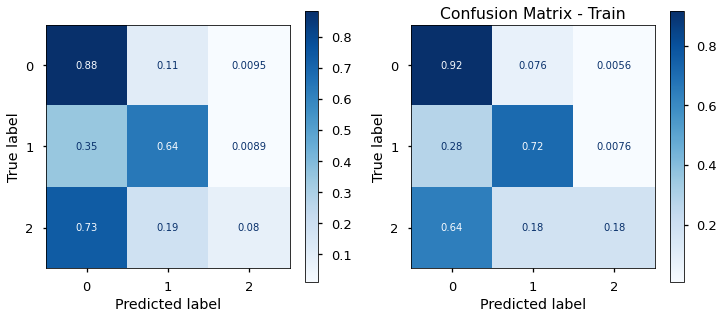



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.719     0.885     0.793      8065
           1      0.777     0.640     0.702      5706
           2      0.402     0.080     0.133      1079

    accuracy                          0.732     14850
   macro avg      0.632     0.535     0.543     14850
weighted avg      0.718     0.732     0.710     14850

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 89.69%
 Test Roc_Auc Score: 81.81%


--------------------------------------------------------


 Train Accuracy Score: 78.69%
 Test Accuracy Score: 73.24%


--------------------------------------------------------


 Train Sensitivity/Recall score: 78.69%
 Test Sensitivity/Recall score: 73.24%


--------------------------------------

In [55]:
model_evaluation_roc_auc(baseline_logreg)

Micro-averaged One-vs-Rest ROC AUC score:
0.89
Micro-averaged One-vs-Rest ROC AUC score:
0.93


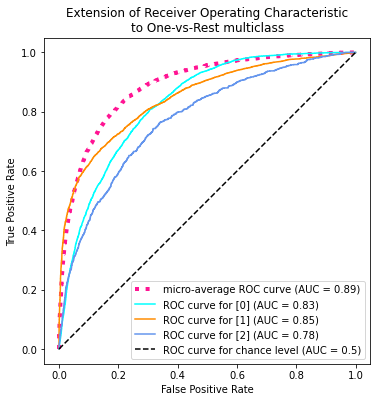

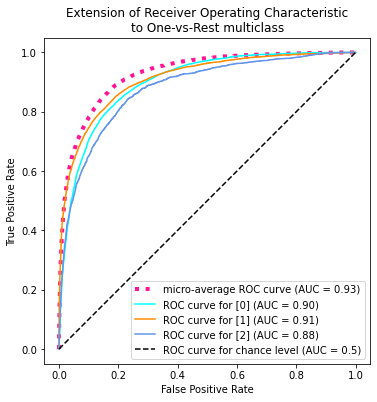

time: 11.3 s (started: 2023-01-04 18:24:13 -05:00)


In [59]:
plot_roc_curve(baseline_logreg,X_test,y_test)
plot_roc_curve(baseline_logreg,X_train,y_train)

In [106]:
cat_features_binary=baseline_logreg['preprocessor'].transformers_[0][1]\
    ['ohe'].get_feature_names_out(X_train_binary.columns)
cat_feature_other = baseline_logreg['preprocessor'].transformers_[1][1]\
    ['ohe'].get_feature_names_out(X_train_cat.columns)
feature_names     = np.r_[cat_features_binary, cat_feature_other,X_train_numeric.columns]
#feature_names = np.r_[X_not_cat.columns, cat_feature_names]


time: 6.52 ms (started: 2023-01-04 19:53:07 -05:00)


In [284]:
# visualize feature importance from a pipeline
def feature_importance_ML(model, modelname):
    coeffs = model.named_steps['estimator'].coef_ 
    importance = pd.Series(abs(coeffs[0]), index=feature_names) # logreg_coeffs[0] = getting the one-dim list inside the list
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots(figsize=(10,6))
        importance.sort_values().tail(20).plot.barh(ax=ax);        
         
        ax.set_xlabel('Feature importance')
        ax.set_ylabel('Features')
        fig.tight_layout()

time: 583 µs (started: 2023-01-09 08:39:22 -05:00)


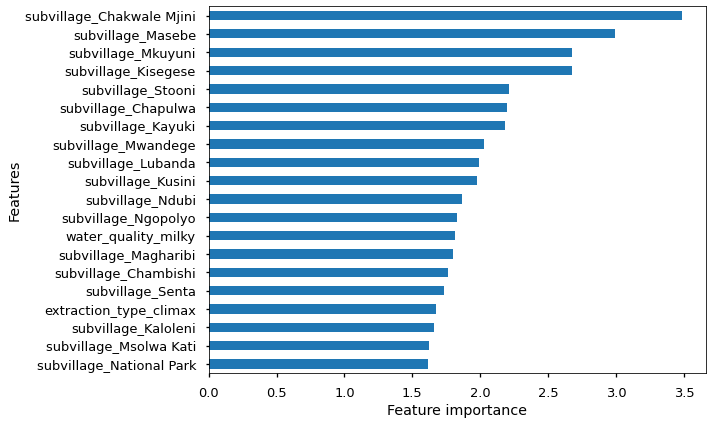

time: 197 ms (started: 2023-01-04 19:53:09 -05:00)


In [108]:
feature_importance_ML(baseline_logreg,"Log Reg")

In [115]:
rfc = RandomForestClassifier(random_state=42,class_weight = 'balanced')

rfc_model_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator",rfc)
])
rfc_model_pipe.fit(X_train, y_train);

time: 4min 18s (started: 2023-01-04 19:55:02 -05:00)


In [187]:
 rfc_model_pipe['estimator'].get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', random_state=42)>

time: 1.57 ms (started: 2023-01-06 12:24:05 -05:00)


In [203]:
rfc2 = RandomForestClassifier(random_state=42,class_weight = 'balanced',
                            min_samples_leaf=2,max_features='log2')

rfc_model_pipe2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator",rfc2)
])
rfc_model_pipe2.fit(X_train, y_train);

time: 36.3 s (started: 2023-01-06 13:03:39 -05:00)


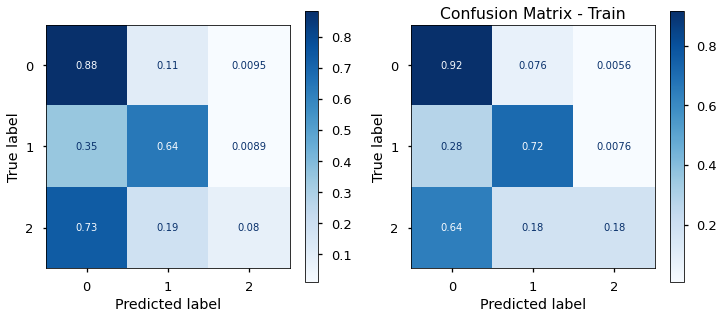



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.743     0.595     0.661      8065
           1      0.655     0.606     0.629      5706
           2      0.172     0.496     0.255      1079

    accuracy                          0.592     14850
   macro avg      0.523     0.566     0.515     14850
weighted avg      0.668     0.592     0.619     14850

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 78.91%
 Test Roc_Auc Score: 75.87%


--------------------------------------------------------


 Train Accuracy Score: 61.26%
 Test Accuracy Score: 59.21%


--------------------------------------------------------


 Train Sensitivity/Recall score: 61.26%
 Test Sensitivity/Recall score: 59.21%


--------------------------------------

In [204]:
model_evaluation_roc_auc(rfc_model_pipe2)

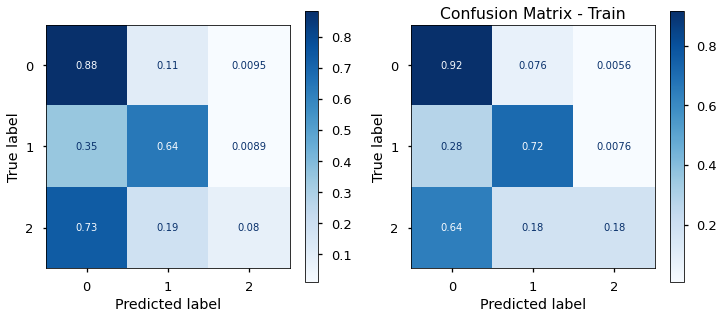



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.799     0.891     0.842      8065
           1      0.841     0.771     0.804      5706
           2      0.536     0.307     0.390      1079

    accuracy                          0.803     14850
   macro avg      0.725     0.656     0.679     14850
weighted avg      0.796     0.803     0.795     14850

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 99.99%
 Test Roc_Auc Score: 88.81%


--------------------------------------------------------


 Train Accuracy Score: 99.92%
 Test Accuracy Score: 80.26%


--------------------------------------------------------


 Train Sensitivity/Recall score: 99.92%
 Test Sensitivity/Recall score: 80.26%


--------------------------------------

In [117]:
model_evaluation_roc_auc(rfc_model_pipe)

Micro-averaged One-vs-Rest ROC AUC score:
0.86
Micro-averaged One-vs-Rest ROC AUC score:
0.84


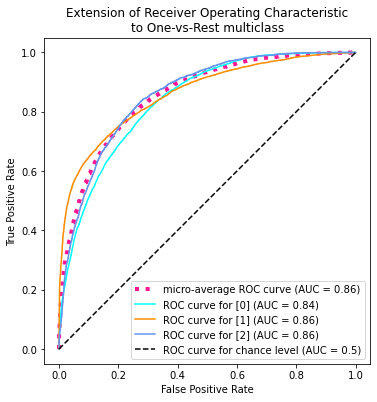

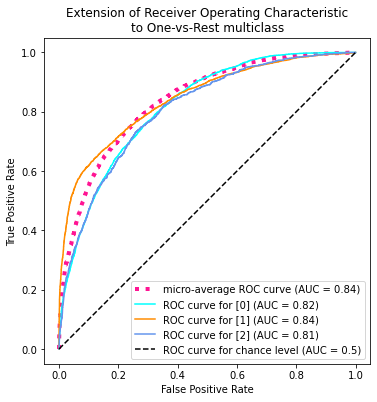

time: 15.6 s (started: 2023-01-06 12:32:01 -05:00)


In [191]:
plot_roc_curve(rfc_model_pipe2,X_train,y_train)
plot_roc_curve(rfc_model_pipe2,X_test,y_test)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Micro-averaged One-vs-Rest ROC AUC score:
0.93


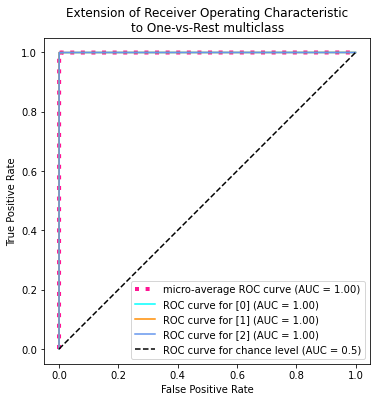

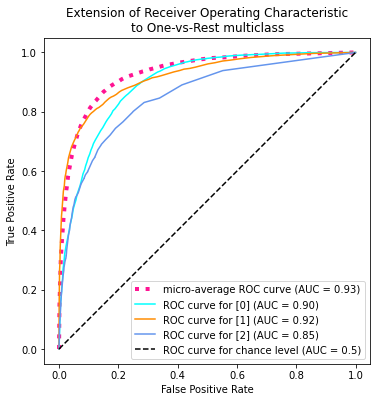

time: 17 s (started: 2023-01-04 20:48:07 -05:00)


In [125]:
plot_roc_curve(rfc_model_pipe,X_train,y_train)
plot_roc_curve(rfc_model_pipe,X_test,y_test)

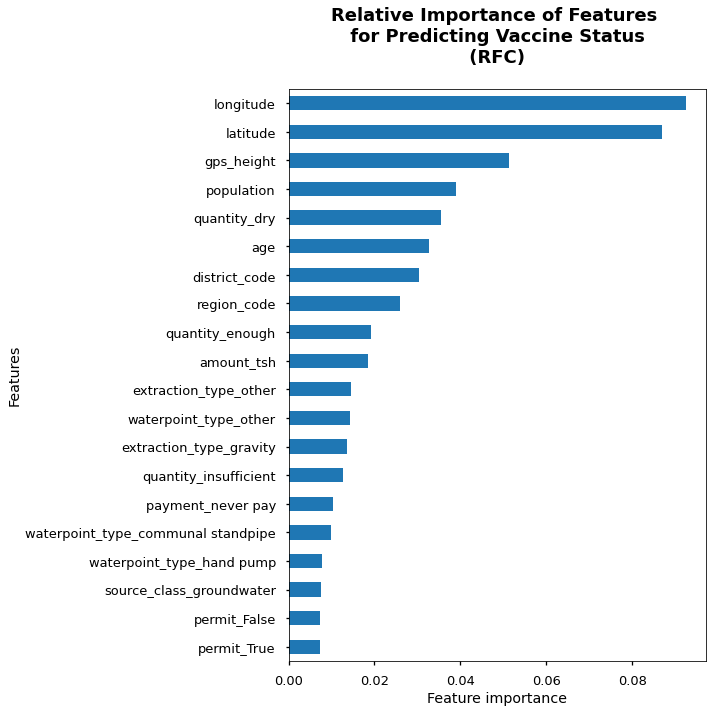

time: 239 ms (started: 2023-01-04 21:00:45 -05:00)


In [150]:
feature_importance_XGB(rfc_model_pipe,"RFC")

In [119]:
clf = XGBClassifier()
xgb_model_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator",clf)
])
xgb_model_pipe.fit(X_train, y_train);

time: 34min 25s (started: 2023-01-04 20:03:15 -05:00)


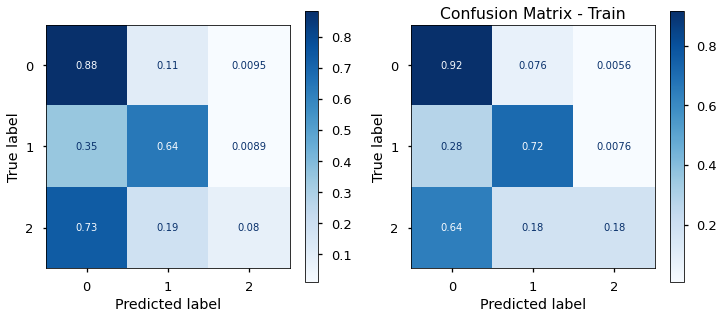



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.751     0.922     0.828      8065
           1      0.846     0.687     0.758      5706
           2      0.647     0.194     0.298      1079

    accuracy                          0.779     14850
   macro avg      0.748     0.601     0.628     14850
weighted avg      0.780     0.779     0.763     14850

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 91.25%
 Test Roc_Auc Score: 87.58%


--------------------------------------------------------


 Train Accuracy Score: 80.40%
 Test Accuracy Score: 77.87%


--------------------------------------------------------


 Train Sensitivity/Recall score: 80.40%
 Test Sensitivity/Recall score: 77.87%


--------------------------------------

In [124]:
model_evaluation_roc_auc(xgb_model_pipe)

Micro-averaged One-vs-Rest ROC AUC score:
0.94
Micro-averaged One-vs-Rest ROC AUC score:
0.92


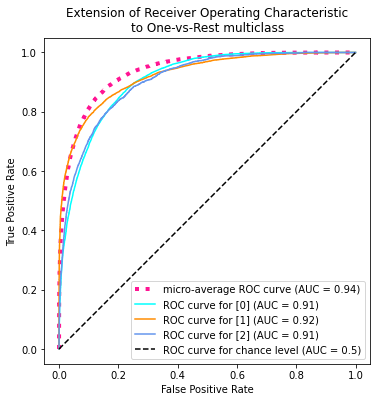

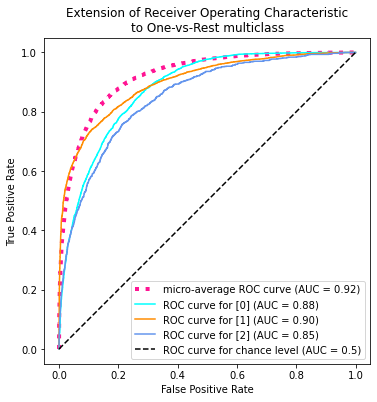

time: 11.3 s (started: 2023-01-04 20:48:51 -05:00)


In [126]:
plot_roc_curve(xgb_model_pipe,X_train,y_train)
plot_roc_curve(xgb_model_pipe,X_test,y_test)

In [285]:
def feature_importance_XGB(model, modelname):
    feature_importances = model.named_steps['estimator'].feature_importances_
    importance = pd.Series(feature_importances, index=feature_names) # always positive value?
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots(figsize=(10,10))
        importance.sort_values().tail(20).plot.barh(ax=ax);
        ax.set_title("Relative Importance of Features \n for Predicting Water Pump Status \n ({}) \n".format(modelname), fontsize=18, fontweight='bold') 
        ax.set_xlabel('Feature importance')
        ax.set_ylabel('Features')
        plt.tight_layout()

time: 477 µs (started: 2023-01-09 08:39:38 -05:00)


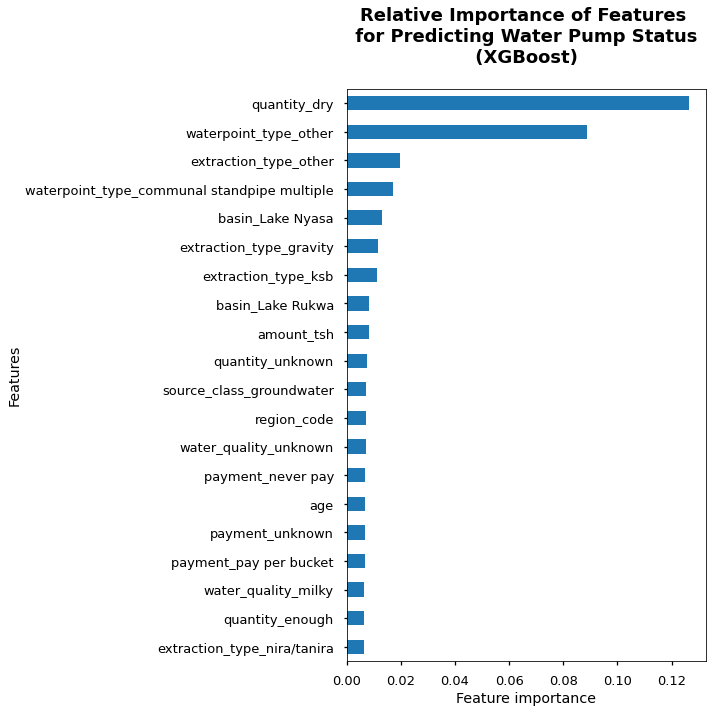

time: 258 ms (started: 2023-01-09 08:39:42 -05:00)


In [286]:
#from xgboost import plot_importance
#xgb_model_pipe.named_steps['estimator'].feature_importances_
#plot_importance(xgb_model_pipe.named_steps['estimator'])
#print(xgb_model_pipe.named_steps['estimator'].feature_importances_)
#plt.bar(range(len(xgb_model_pipe.named_steps['estimator'].feature_importances_)), xgb_model_pipe.named_steps['estimator'].feature_importances_)
#plt.show()
feature_importance_XGB(xgb_model_pipe, "XGBoost")

In [152]:
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

time: 5.56 ms (started: 2023-01-06 12:01:41 -05:00)


In [226]:
# Baseline model preprocessed and fit to a Random Forest Classifier
baseline_model_RF = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", RandomForestClassifier(random_state=42, class_weight = "balanced"))
])

# Hyperparameters used for model tuning
parameters = {
    'estimator__n_estimators': [150],                 # default=100 Number of trees.
    'estimator__criterion': ['entropy', 'gini'],      # default = gini
    'estimator__max_depth': [5, 7,9],                   # default = None, Lower depth prevents overfitting
    'estimator__max_features': ['sqrt', 'log'],             # default = None (n_features), Lower values prevent overfitting  
    'estimator__min_samples_split': [5, 10,20],      # default = 2, Higher values prevent overfitting 
    'estimator__min_samples_leaf': [2, 4,6]          # default = 1, Higher values prevent overfitting 
}   

# Create the grid, with "baseline_RF_insurance" as the estimator
#best_model_RF = GridSearchCV(estimator = baseline_model_RF,   # model
#                          param_grid = parameters,                    # hyperparameters
#                          scoring ='f1_weighted',                     # metric for scoring
#                          cv = 3,                                     # number of folds for cross-validation
#                          n_jobs = -1                                 # 1 job per core of the computer.
#)                      
best_model_RF = HalvingGridSearchCV(estimator = baseline_model_RF,   # model
                          param_grid = parameters,                    # hyperparameters
                          scoring ='f1_weighted',                     # metric for scoring
                          cv = 3,                                     # number of folds for cross-validation
                          n_jobs = -1                                 # 1 job per core of the computer.
)       

# Train the pipeline (tranformations & predictor)
best_model_RF.fit(X_train, y_train);

time: 5min 15s (started: 2023-01-06 13:35:05 -05:00)


In [228]:
best_model_RF.best_estimator_[-1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

time: 2.06 ms (started: 2023-01-06 13:42:50 -05:00)


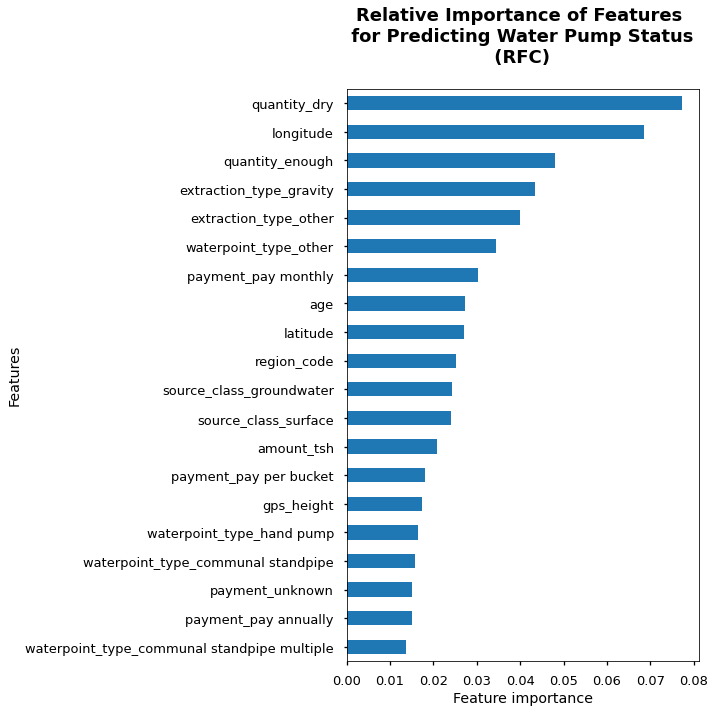

time: 258 ms (started: 2023-01-09 08:39:57 -05:00)


In [287]:
feature_importance_XGB(best_model_RF.best_estimator_,"RFC")

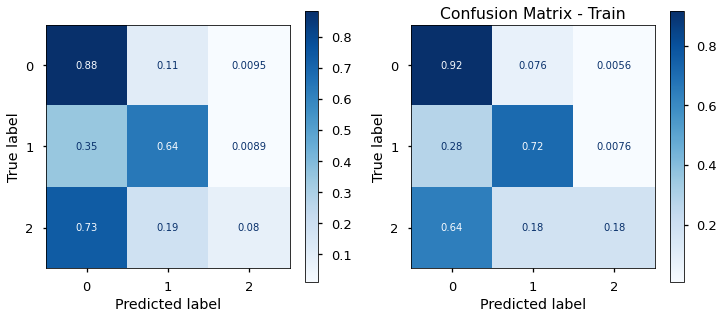



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.749     0.656     0.700      8065
           1      0.716     0.617     0.663      5706
           2      0.191     0.510     0.278      1079

    accuracy                          0.630     14850
   macro avg      0.552     0.594     0.547     14850
weighted avg      0.696     0.630     0.655     14850

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 79.58%
 Test Roc_Auc Score: 78.25%


--------------------------------------------------------


 Train Accuracy Score: 63.90%
 Test Accuracy Score: 63.02%


--------------------------------------------------------


 Train Sensitivity/Recall score: 63.90%
 Test Sensitivity/Recall score: 63.02%


--------------------------------------

In [230]:
model_evaluation_roc_auc(best_model_RF.best_estimator_)

In [238]:
baseline_model_LR = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(random_state=42,multi_class='multinomial'))])

parameters = {
    'estimator__penalty' : ['l1','l2'], # default = l2 elasticnet is both
    'estimator__fit_intercept':[True, False],
    'estimator__C'       : [0.001,0.01,0.1,1,10,100], #np.logspace(-3,3,7) # default=1.0
    'estimator__solver'  : ['newton-cg', 'lbfgs', 'liblinear'], # default = ’lbfgs’
    'estimator__max_iter'  : [50,100]  # default = 100
}

best_model_LR = HalvingGridSearchCV(estimator = baseline_model_LR,   # model
                          param_grid = parameters,                    # hyperparameters
                          scoring ='f1_weighted',                     # metric for scoring
                          cv = 3,                                     # number of folds for cross-validation
                          n_jobs = -1                                 # 1 job per core of the computer.
)

# Train the pipeline (tranformations & predictor)
best_model_LR.fit(X_train, y_train);

time: 3h 52min 46s (started: 2023-01-06 13:57:34 -05:00)


In [195]:
def get_params_pipe_model(model):
    for param, value in model[-1].get_params(deep=True).items():
        print(f"{param} -> {value}")

time: 338 µs (started: 2023-01-06 12:37:00 -05:00)


In [239]:
best_model_LR.best_params_

{'estimator__C': 1,
 'estimator__fit_intercept': True,
 'estimator__max_iter': 50,
 'estimator__penalty': 'l2',
 'estimator__solver': 'newton-cg'}

time: 2.76 ms (started: 2023-01-06 18:03:34 -05:00)


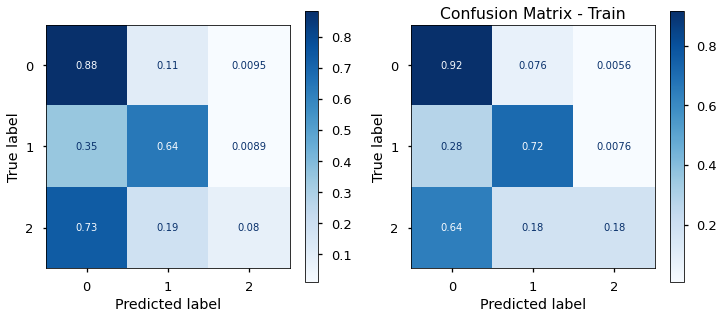



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.727     0.889     0.800      8065
           1      0.786     0.654     0.714      5706
           2      0.479     0.104     0.171      1079

    accuracy                          0.742     14850
   macro avg      0.664     0.549     0.562     14850
weighted avg      0.732     0.742     0.721     14850

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 93.11%
 Test Roc_Auc Score: 82.77%


--------------------------------------------------------


 Train Accuracy Score: 81.70%
 Test Accuracy Score: 74.19%


--------------------------------------------------------


 Train Sensitivity/Recall score: 81.70%
 Test Sensitivity/Recall score: 74.19%


--------------------------------------

In [241]:
model_evaluation_roc_auc(best_model_LR)

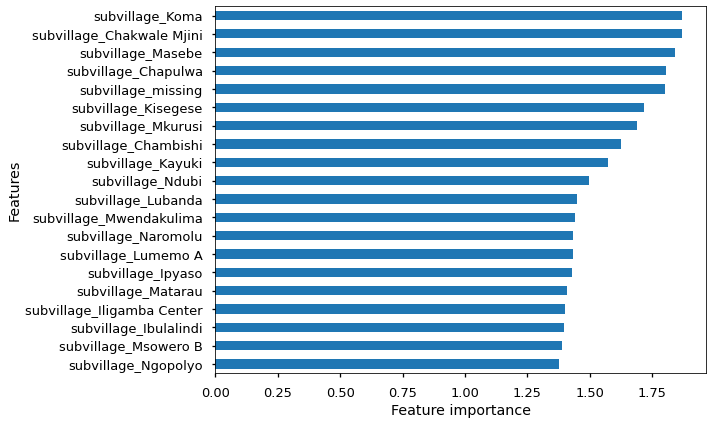

time: 206 ms (started: 2023-01-06 18:53:31 -05:00)


In [243]:
feature_importance_ML(best_model_LR.best_estimator_,"Log REg")

In [196]:
get_params_pipe_model(baseline_logreg)

C -> 1.0
class_weight -> None
dual -> False
fit_intercept -> True
intercept_scaling -> 1
l1_ratio -> None
max_iter -> 100
multi_class -> auto
n_jobs -> None
penalty -> l2
random_state -> 42
solver -> lbfgs
tol -> 0.0001
verbose -> 0
warm_start -> False
time: 605 µs (started: 2023-01-06 12:37:13 -05:00)


In [197]:
get_params_pipe_model(rfc_model_pipe)

bootstrap -> True
ccp_alpha -> 0.0
class_weight -> balanced
criterion -> gini
max_depth -> None
max_features -> sqrt
max_leaf_nodes -> None
max_samples -> None
min_impurity_decrease -> 0.0
min_samples_leaf -> 1
min_samples_split -> 2
min_weight_fraction_leaf -> 0.0
n_estimators -> 100
n_jobs -> None
oob_score -> False
random_state -> 42
verbose -> 0
warm_start -> False
time: 478 µs (started: 2023-01-06 12:37:28 -05:00)


In [205]:
get_params_pipe_model(xgb_model_pipe)

objective -> multi:softprob
use_label_encoder -> None
base_score -> 0.5
booster -> gbtree
callbacks -> None
colsample_bylevel -> 1
colsample_bynode -> 1
colsample_bytree -> 1
early_stopping_rounds -> None
enable_categorical -> False
eval_metric -> None
feature_types -> None
gamma -> 0
gpu_id -> -1
grow_policy -> depthwise
importance_type -> None
interaction_constraints -> 
learning_rate -> 0.300000012
max_bin -> 256
max_cat_threshold -> 64
max_cat_to_onehot -> 4
max_delta_step -> 0
max_depth -> 6
max_leaves -> 0
min_child_weight -> 1
missing -> nan
monotone_constraints -> ()
n_estimators -> 100
n_jobs -> 0
num_parallel_tree -> 1
predictor -> auto
random_state -> 0
reg_alpha -> 0
reg_lambda -> 1
sampling_method -> uniform
scale_pos_weight -> None
subsample -> 1
tree_method -> exact
validate_parameters -> 1
verbosity -> None
time: 34.9 ms (started: 2023-01-06 13:05:48 -05:00)


In [245]:
baseline_model_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", XGBClassifier(random_state=42))])

parameters = {
    "estimator__n_estimators": [75],              # default = 100, To avoid overfitting use "fewer" trees unlike RF.
    "estimator__learning_rate": [0.05, 0.2], # default = 0.3, Lower ratios avoid over-fitting. If you reduce the learning rate in your XGBoost model, your model will also be less likely to overfit. 
    "estimator__max_depth": [4, 6],            # default = 6, It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    'estimator__gamma': [0.5, 1],                 # default = 0 , Larger values avoid over-fitting.
    'estimator__min_child_weight': [3, 4, 5],     # default = 1, Larger values avoid over-fitting. The larger min_child_weight is, the more conservative the algorithm will be. 
    'estimator__subsample': [0.5, 0.75],          # default = 1, Lower ratios avoid over-fitting.
    'estimator__colsample_bytree':[0.5, 0.75]     # default = 1, Lower ratios avoid over-fitting.
}

best_model_xgb = HalvingGridSearchCV(estimator = baseline_model_xgb,       
                        param_grid = parameters,     
                        scoring ='f1_weighted',          
                        cv = 3,
                        n_jobs = -1
)                      

# Train the pipeline (tranformations & predictor)ui0
best_model_xgb.fit(X_train, y_train);

time: 3h 58s (started: 2023-01-06 18:57:27 -05:00)


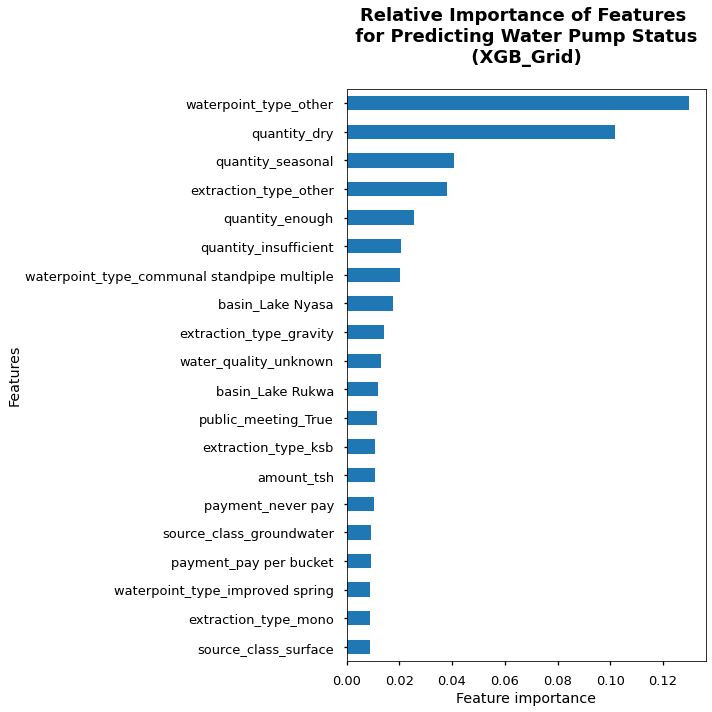

time: 213 ms (started: 2023-01-09 08:40:10 -05:00)


In [288]:
feature_importance_XGB(best_model_xgb.best_estimator_,"XGB_Grid")

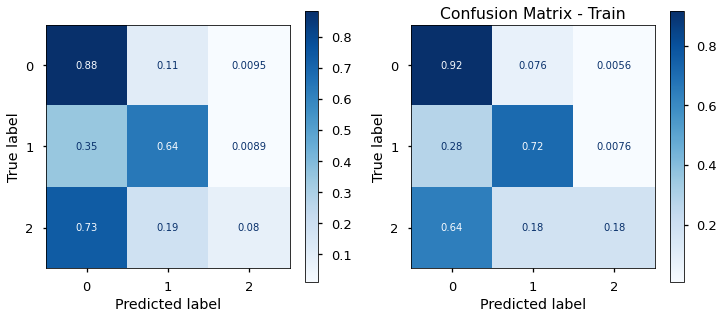



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.751     0.922     0.828      8065
           1      0.840     0.684     0.754      5706
           2      0.649     0.185     0.288      1079

    accuracy                          0.777     14850
   macro avg      0.747     0.597     0.623     14850
weighted avg      0.778     0.777     0.760     14850

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 90.59%
 Test Roc_Auc Score: 87.75%


--------------------------------------------------------


 Train Accuracy Score: 79.58%
 Test Accuracy Score: 77.70%


--------------------------------------------------------


 Train Sensitivity/Recall score: 79.58%
 Test Sensitivity/Recall score: 77.70%


--------------------------------------

In [248]:
model_evaluation_roc_auc(best_model_xgb)

Micro-averaged One-vs-Rest ROC AUC score:
0.93
Micro-averaged One-vs-Rest ROC AUC score:
0.92


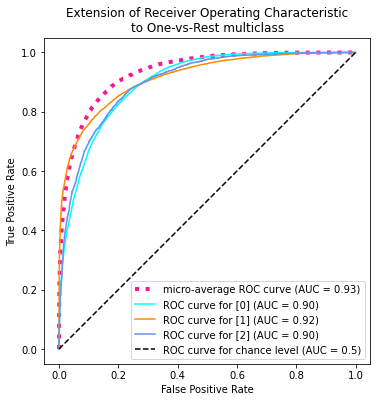

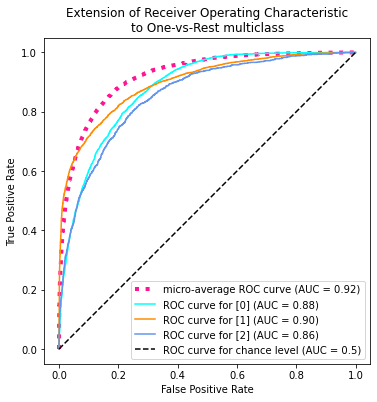

time: 10.4 s (started: 2023-01-06 22:29:41 -05:00)


In [250]:
plot_roc_curve(best_model_xgb,X_train,y_train)
plot_roc_curve(best_model_xgb,X_test,y_test)

In [252]:
best_model_xgb.best_estimator_.named_steps['estimator']

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=75, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

time: 5.78 ms (started: 2023-01-07 08:20:58 -05:00)


In [251]:
best_model_LR.best_estimator_.named_steps['estimator']

LogisticRegression(C=1, max_iter=50, multi_class='multinomial', random_state=42,
                   solver='newton-cg')

time: 2.56 ms (started: 2023-01-07 08:10:48 -05:00)


In [253]:
best_model_RF.best_estimator_.named_steps['estimator']

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150, random_state=42)

time: 3.14 ms (started: 2023-01-07 08:21:21 -05:00)


In [255]:
from sklearn.ensemble import StackingClassifier

time: 577 µs (started: 2023-01-07 08:22:01 -05:00)


In [256]:
# Meta learner is Logistic Regression and the base learners are Random Forest, Logistic Regression and XGBoost 
# Stacking often considers heterogeneous weak learners, learns them in parallel, and combines them by training a meta-learner to output a prediction based on the different weak learner’s predictions. 

base_learners = [
                ('logreg', best_model_LR.best_estimator_.named_steps['estimator']),
                ('RF', best_model_RF.best_estimator_.named_steps['estimator']),   # uses bagging (another ensemble technique)
                ('XGB', best_model_xgb.best_estimator_.named_steps['estimator'])  # uses boosting (another ensemble technique)
                ]

ensemble = StackingClassifier(estimators=base_learners, 
                              final_estimator = XGBClassifier(), 
                              cv=3, 
                              passthrough=False, 
                              n_jobs=-1)

stacked_model = Pipeline([
        ("preprocessor", preprocessor),
        ('ensemble',ensemble)
])

stacked_model.fit(X_train, y_train);

time: 7h 4min 39s (started: 2023-01-07 08:22:02 -05:00)


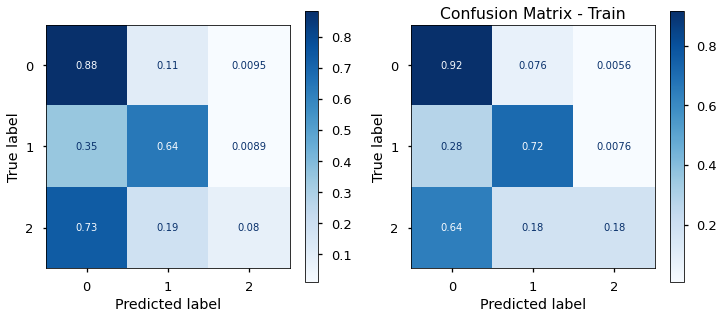



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.763     0.902     0.827      8065
           1      0.827     0.708     0.763      5706
           2      0.580     0.234     0.334      1079

    accuracy                          0.779     14850
   macro avg      0.723     0.615     0.641     14850
weighted avg      0.774     0.779     0.766     14850

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 92.13%
 Test Roc_Auc Score: 87.53%


--------------------------------------------------------


 Train Accuracy Score: 81.85%
 Test Accuracy Score: 77.88%


--------------------------------------------------------


 Train Sensitivity/Recall score: 81.85%
 Test Sensitivity/Recall score: 77.88%


--------------------------------------

In [257]:
model_evaluation_roc_auc(stacked_model)

In [261]:
stacked_model.named_steps

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('preprocess_binary',
                                  Pipeline(steps=[('binary_impute',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('ohe',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  ['public_meeting', 'permit']),
                                 ('preprocess_categorical',
                                  Pipeline(steps=[('cat_impute',
                                                   SimpleImputer(fill_value='missing',
                                                                 strategy='constan...
                                  ['basin', 'subvillage', 'extraction_type',
                                   'management_group'

time: 26.2 ms (started: 2023-01-07 16:23:09 -05:00)


In [273]:
roc_auc_score(y_train, best_model_RF.predict_proba(X_train),multi_class='ovr') 

0.7958285574635743

time: 8.59 s (started: 2023-01-07 19:24:53 -05:00)


In [274]:
roc_auc_score(y_train, best_model_LR.predict_proba(X_train),multi_class='ovr') 

0.9311001881605073

time: 6.78 s (started: 2023-01-07 19:25:34 -05:00)


In [275]:
roc_auc_score(y_train, best_model_xgb.predict_proba(X_train),multi_class='ovr') 

0.9058720284867391

time: 7.87 s (started: 2023-01-07 19:25:43 -05:00)


In [276]:
roc_auc_score(y_train, stacked_model.predict_proba(X_train),multi_class='ovr') 

0.9213306260104325

time: 11.2 s (started: 2023-01-07 19:25:52 -05:00)


In [277]:
def compare_roc_auc(names, models):

    cv_roc_auc_scores = []
    train_roc_auc_scores = []
    test_roc_auc_scores = []

    for i in range(len(names)):
        score_train_cv = cross_val_score(estimator=models[i], X=X_train,  y=y_train,
                                         cv=StratifiedKFold(shuffle=True), scoring='roc_auc_ovr').mean()
        
        score_train = roc_auc_score(y_train, models[i].predict_proba(X_train),multi_class='ovr') 
        score_test = roc_auc_score(y_test, models[i].predict_proba(X_test),multi_class='ovr')
        
        cv_roc_auc_scores.append(score_train_cv)
        train_roc_auc_scores.append(score_train)
        test_roc_auc_scores.append(score_test)
        
    scores_table = pd.DataFrame(list(zip(cv_roc_auc_scores, train_roc_auc_scores, test_roc_auc_scores)),
                             columns =['cv_train', 'train', 'test'], index = names)
    return(scores_table)


time: 1.53 ms (started: 2023-01-07 19:26:08 -05:00)


In [264]:
cross_val_score(best_model_LR.best_estimator_,X=X_train,  y=y_train,cv=StratifiedKFold(shuffle=True), scoring='roc_auc_ovr').mean()

0.8255891375564793

time: 37min 33s (started: 2023-01-07 16:31:06 -05:00)


In [279]:
names = ["Logistic Regression", "Random_Forest", "XG Boost"]#, "Stacked Model"]
models = [best_model_LR.best_estimator_, 
          best_model_RF.best_estimator_, best_model_xgb.best_estimator_]#, stacked_model]

df_scores=compare_roc_auc(names, models)

time: 1h 26min 7s (started: 2023-01-08 10:52:27 -05:00)


In [280]:
df_scores

,cv_train,train,test
Logistic Regression,0.827096,0.931100,0.827683
Random_Forest,0.780599,0.795829,0.782454
XG Boost,0.877268,0.905872,0.877508


time: 12.9 ms (started: 2023-01-08 14:11:11 -05:00)


In [ ]:
from sklearn.feature_selection import SelectFromModel


In [281]:
score_train_cv_stacked = cross_val_score(estimator=stacked_model, X=X_train,  y=y_train,
                                         cv=StratifiedKFold(shuffle=True), scoring='roc_auc_ovr').mean()
score_train_stacked = roc_auc_score(y_train, stacked_model.predict_proba(X_train),multi_class='ovr') 
score_test_stacked  = roc_auc_score(y_test, stacked_model.predict_proba(X_test),multi_class='ovr')
print(score_train_cv_stacked,score_train_stacked,score_test_stacked)

0.8725677860247358 0.9213306260104325 0.8752554146270765
time: 13h 8min 35s (started: 2023-01-08 14:40:21 -05:00)


In [282]:
new_row = {'cv_train':score_train_cv_stacked, 'train':score_train_stacked, 'test':score_test_stacked}
dfscores = df_scores.append(pd.DataFrame([new_row],index=['Stacked'],columns=df_scores.columns))
print(dfscores)

                     cv_train     train      test
Logistic Regression  0.827096  0.931100  0.827683
Random_Forest        0.780599  0.795829  0.782454
XG Boost             0.877268  0.905872  0.877508
Stacked              0.872568  0.921331  0.875255
time: 7.07 ms (started: 2023-01-09 08:38:21 -05:00)


In [283]:
dfscores

,cv_train,train,test
Logistic Regression,0.827096,0.931100,0.827683
Random_Forest,0.780599,0.795829,0.782454
XG Boost,0.877268,0.905872,0.877508
Stacked,0.872568,0.921331,0.875255


time: 4.51 ms (started: 2023-01-09 08:38:29 -05:00)
